<a href="https://colab.research.google.com/github/ikechiamaka/Access-control-with-voice-recognition-and-RFID-/blob/main/SNRBERDatasetGEn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import pandas as pd
import numpy as np


# Load the weather data from a CSV file
weather_data = pd.read_csv("cleaned_weather_data.csv")


In [ ]:
weather_data

,dt_iso,dt,timezone,city_name,lat,lon,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1983-01-01 00:00:00+00:00,410227200,-18000,Ottawa,45.42153,-75.697193,-2.87,-6.25,-6.78,-3.29,-2.50,1021,75,2.83,185,100,804,Clouds,overcast clouds,04n
1,1983-01-01 01:00:00+00:00,410230800,-18000,Ottawa,45.42153,-75.697193,-2.95,-6.32,-6.86,-3.39,-2.57,1021,75,2.82,192,99,804,Clouds,overcast clouds,04n
2,1983-01-01 02:00:00+00:00,410234400,-18000,Ottawa,45.42153,-75.697193,-2.83,-5.75,-6.68,-3.27,-2.44,1020,78,2.78,205,99,804,Clouds,overcast clouds,04n
3,1983-01-01 03:00:00+00:00,410238000,-18000,Ottawa,45.42153,-75.697193,-2.84,-5.47,-6.82,-3.29,-2.43,1019,80,2.91,214,97,804,Clouds,overcast clouds,04n
4,1983-01-01 04:00:00+00:00,410241600,-18000,Ottawa,45.42153,-75.697193,-2.97,-5.31,-7.19,-3.41,-2.58,1019,82,3.13,221,76,803,Clouds,broken clouds,04n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371999,2023-02-18 19:00:00+00:00,1676746800,-18000,Ottawa,45.42153,-75.697193,-1.29,-6.37,-6.61,-2.33,-0.16,1018,65,5.14,210,100,600,Snow,light snow,13d
372000,2023-02-18 20:00:00+00:00,1676750400,-18000,Ottawa,45.42153,-75.697193,-0.65,-5.76,-6.10,-1.57,0.02,1018,65,5.66,230,100,600,Snow,light snow,13d
372001,2023-02-18 21:00:00+00:00,1676754000,-18000,Ottawa,45.42153,-75.697193,-0.67,-5.08,-6.63,-1.22,-0.04,1019,69,6.69,240,100,600,Snow,light snow,13d
372002,2023-02-18 22:00:00+00:00,1676757600,-18000,Ottawa,45.42153,-75.697193,-1.03,-4.77,-6.58,-1.62,-0.16,1019,73,5.66,230,100,600,Snow,light snow,13d


In [ ]:
tx_power = 20 # dBm
rx_sensitivity = -100 # dBm
frequency = 2.4 # GHz
c = 3e8 # m/s
lambda_ = c / (frequency * 1e9) # wavelength in meters
tx_antenna_gain = 1 # dBi
rx_antenna_gain = 1 # dBi
distance = 1000 # meters


In [ ]:
# Define a function to calculate the free space path loss
def calculate_friis_loss(distance, frequency, tx_antenna_gain, rx_antenna_gain):
    gain = tx_antenna_gain + rx_antenna_gain
    return 20 * math.log10(distance) + 20 * math.log10(frequency) - 147.55 - gain

# Define a function to calculate the weather loss
def calculate_weather_loss(temperature, humidity, pressure):
    vapor_pressure = humidity * pressure / 100
    saturation_vapor_pressure = 6.11 * 10 ** (7.5 * temperature / (237.3 + temperature))
    water_vapor_density = 1000 * vapor_pressure / (287.058 * (temperature + 273.15))
    attenuation = 0.0172 * water_vapor_density * (1 + 0.0004 * frequency) / (math.sin(0.5 * lambda_)) ** 0.5
    return attenuation * distance / 1000

In [ ]:
# Initialize an empty DataFrame to store the SNR and BER values
snr_ber_data = pd.DataFrame(columns=["temperature", "humidity", "pressure", "snr", "ber","Capacity","Bandwidth"])

In [ ]:
snr_ber_data

,temperature,humidity,pressure,snr,ber,Capacity,Bandwidth


In [ ]:
# Initialize an empty list to store the SNR, BER, capacity, and bandwidth values
snr_ber_data = []
threshold_snr = 1e-10 # set a threshold SNR value below which the BER is set to 0.5 (random guessing)
bandwidth = 10e6  # set the bandwidth to 10 MHz

# Iterate over the weather data and calculate the SNR, BER, capacity, and bandwidth for each combination of weather conditions
for index, row in weather_data.iterrows():
    # Get the weather conditions for this row
    temperature = row["temp"]
    humidity = row["humidity"]
    pressure = row["pressure"]
    date_time = row["dt_iso"] # assuming there is a "datetime" column in the weather_data DataFrame

    # Calculate the free space path loss
    friis_loss = calculate_friis_loss(distance, frequency, tx_antenna_gain, rx_antenna_gain)

    # Calculate the weather loss
    weather_loss = calculate_weather_loss(temperature, humidity, pressure)

    # Calculate the SNR
    snr = tx_power - rx_sensitivity - friis_loss - weather_loss

    # Check if the SNR is negative
    if snr < threshold_snr:
        ber = 0.5
    else:
        # Calculate the BER for 0QPSK modulation
        ber = 0.5 * math.erfc(math.sqrt(snr))

    # Calculate the capacity
    capacity = bandwidth * (np.log2(1 + snr / 3.01))

    # Append the SNR, BER, capacity, and bandwidth values to the list
    snr_ber_data.append({
        "datetime": date_time,
        "temperature": temperature,
        "humidity": humidity,
        "pressure": pressure,
        "snr": snr,
        "ber": ber,
        "capacity": capacity,
        "bandwidth": bandwidth
    })

# Create a DataFrame from the list and set the datetime column as the index
snr_ber_data = pd.DataFrame(snr_ber_data)
snr_ber_data.set_index("datetime", inplace=True)


In [ ]:
snr_ber_data

,temperature,humidity,pressure,snr,ber,capacity,bandwidth
datetime,,,,,,,
1983-01-01 00:00:00+00:00,-2.87,75,1021,201.265867,7.740733e-90,6.686574e+08,10000000.0
1983-01-01 01:00:00+00:00,-2.95,75,1021,201.265666,7.742296e-90,6.686567e+08,10000000.0
1983-01-01 02:00:00+00:00,-2.83,78,1020,201.239468,7.948323e-90,6.685697e+08,10000000.0
1983-01-01 03:00:00+00:00,-2.84,80,1019,201.222041,8.088400e-90,6.685118e+08,10000000.0
1983-01-01 04:00:00+00:00,-2.97,82,1019,201.203591,8.239395e-90,6.684505e+08,10000000.0
...,...,...,...,...,...,...,...
2023-02-18 19:00:00+00:00,-1.29,65,1018,201.361668,7.031917e-90,6.689756e+08,10000000.0
2023-02-18 20:00:00+00:00,-0.65,65,1018,201.363040,7.022253e-90,6.689802e+08,10000000.0
2023-02-18 21:00:00+00:00,-0.67,69,1019,201.326526,7.284058e-90,6.688589e+08,10000000.0


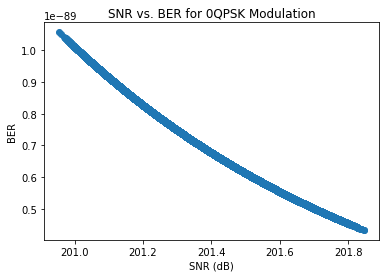

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of SNR vs. BER
plt.scatter(snr_ber_data["snr"], snr_ber_data["ber"])

# Set the title and axis labels
plt.title("SNR vs. BER for 0QPSK Modulation")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")

# Show the plot
plt.show()


In [ ]:
# Save the SNR and BER dataset to a CSV file
snr_ber_data.to_csv("snr_ber_data.csv", index=True)